In [1]:
# IMPORT REQUIRED LIBRARIES

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from abess import LinearRegression as ABESS_LR # Adaptive BEst Subset Selection
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from models import PCR, SPCA_LR, SFS_LR, SFS_QR, PLSR

from tqdm.notebook import tqdm

SEED = 9

In [2]:
# IMPORT PROCESSED DATA

abs_df = pd.read_csv("C:\\Users\\argan\\OneDrive\\Desktop\\DDP\\Final Data\\AvgAbs.csv", index_col=0)

wavelengths = abs_df.iloc[:, :-1].columns

### Removing Outliers - Visual Inspection (EDA)

Scatter plot of Absorbance Value at 485 nm v/s Brix Values - Outlier has lowest Brix value.

In [3]:
abs_df = abs_df.iloc[1:, :]

### SFS LR

In [56]:
# Grid Search

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

parameters = {'n_features_to_select': [8, 9, 10, 11, 12, 13, 14, 15, 16], 'alpha': [1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0]}

model_rmse = np.zeros((9, 8))

for i, n in enumerate(parameters['n_features_to_select']):
    for j, a in enumerate(parameters['alpha']):
        m = SFS_LR(n_features_to_select=n, alpha=a)

        kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                                
        val_metrics = cross_validate(m,
                                     X, y,
                                     scoring=["neg_mean_squared_error"],
                                     cv=kf,
                                     n_jobs=-1, 
                                     verbose=0)
        
        model_rmse[i, j] = np.sqrt(np.mean(-val_metrics["test_neg_mean_squared_error"]))

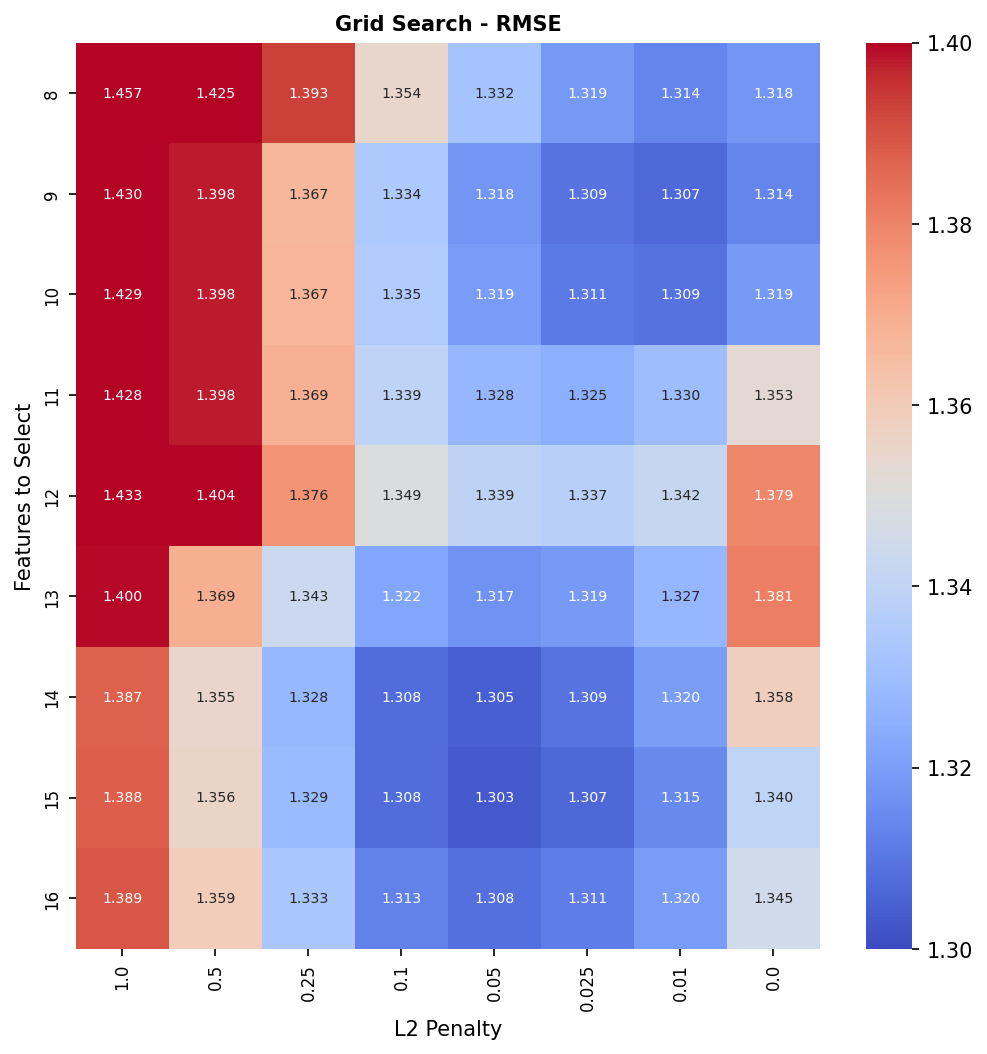

In [58]:
# Plot grid search results

grid_search = pd.DataFrame(model_rmse)
grid_search.columns = parameters['alpha']
grid_search.index = parameters['n_features_to_select']

plt.figure(figsize=(8, 8), dpi=150)

sns.heatmap(grid_search, 
            annot=grid_search.round(decimals=3), 
            fmt=".3f", 
            vmin=1.3, vmax=1.4, 
            cmap="coolwarm", 
            annot_kws={"size":6.75},
            linewidths=0, 
            linecolor='black')

plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8)

plt.xlabel("L2 Penalty")
plt.ylabel("Features to Select")

plt.title("Grid Search - RMSE", fontweight="bold", fontsize=10)
plt.show()

In [7]:
# Train and validate on optimal hyperparameters.

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

regressor = SFS_LR(n_features_to_select=15, alpha=0.05)

regressor.fit(X, y)

y_pred = regressor.predict(X).squeeze()

# Calculate Standardized Residuals
std = np.std(y.squeeze()-y_pred.squeeze())

res = (y.squeeze()-y_pred.squeeze())/std

# Calculate Validation Metrics
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                         
val_metrics = cross_validate(regressor,
                             X, y,
                             scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                             cv=kf,
                             n_jobs=-1, 
                             verbose=0)

print("TRAINING: -")
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
print("MAE:", np.sqrt(mean_absolute_error(y, y_pred)))
print("R2 Score:", r2_score(y, y_pred))
print()
print("VALIDATION: -")
print("RMSE:", np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error'])), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_squared_error']))
print("MAE:", -np.mean(val_metrics['test_neg_mean_absolute_error']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_absolute_error']))
print("R2 Score:", np.mean(val_metrics['test_r2']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_r2']))

TRAINING: -
RMSE: 1.191542083172536
MAE: 0.973396883161903
R2 Score: 0.4609023321247837

VALIDATION: -
RMSE: 1.3033240071236702, Standard Deviation: 0.4557530517938224
MAE: 1.0130303791865884, Standard Deviation: 0.14044151833838106
R2 Score: 0.32672786214501476, Standard Deviation: 0.10645113705846083


Residual Analysis

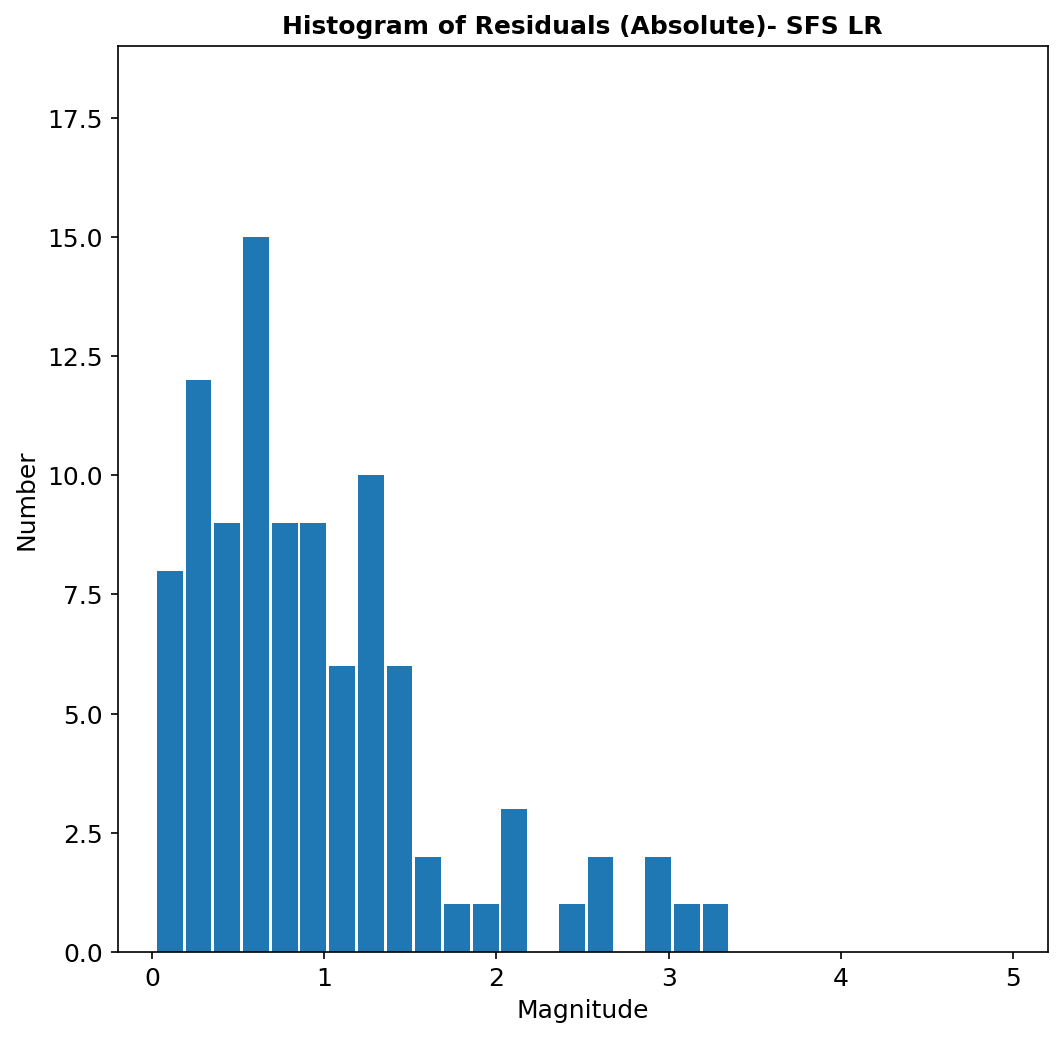

In [9]:
plt.figure(figsize=(8, 8), dpi=150)
plt.hist(np.abs(y-y_pred), bins=20, rwidth=0.9)
plt.xlim(-0.2, 5.2)
plt.ylim(0, 19)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Magnitude", fontsize=12)
plt.ylabel("Number", fontsize=12)

plt.title("Histogram of Residuals (Absolute)- SFS LR", fontsize=12, fontweight='bold')
plt.show()

In [22]:
# Grid Search 2 - Redundant - Plotting purpose

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

components = np.arange(1, 18, 1)

train_rmse = np.zeros(len(components))

cv_rmse = np.zeros(len(components))
cv_rmse_std = np.zeros(len(components))

for i in range(1, 18):

    regressor = SFS_LR(n_features_to_select=i, alpha=0.05)

    regressor.fit(X, y)

    y_pred = regressor.predict(X).squeeze()

    rmse_train = np.sqrt(mean_squared_error(y, y_pred))

    # Calculate Cross-Validation Metrics
    kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                            
    val_metrics = cross_validate(regressor,
                                 X, y,
                                 scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                                 cv=kf,
                                 n_jobs=-1, 
                                 verbose=0)
    
    rmse_cv = np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error']))
    rmse_std_cv = np.std(-val_metrics['test_neg_mean_squared_error'])

    train_rmse[i-1] = rmse_train
    cv_rmse[i-1] = rmse_cv
    cv_rmse_std[i-1] = rmse_std_cv

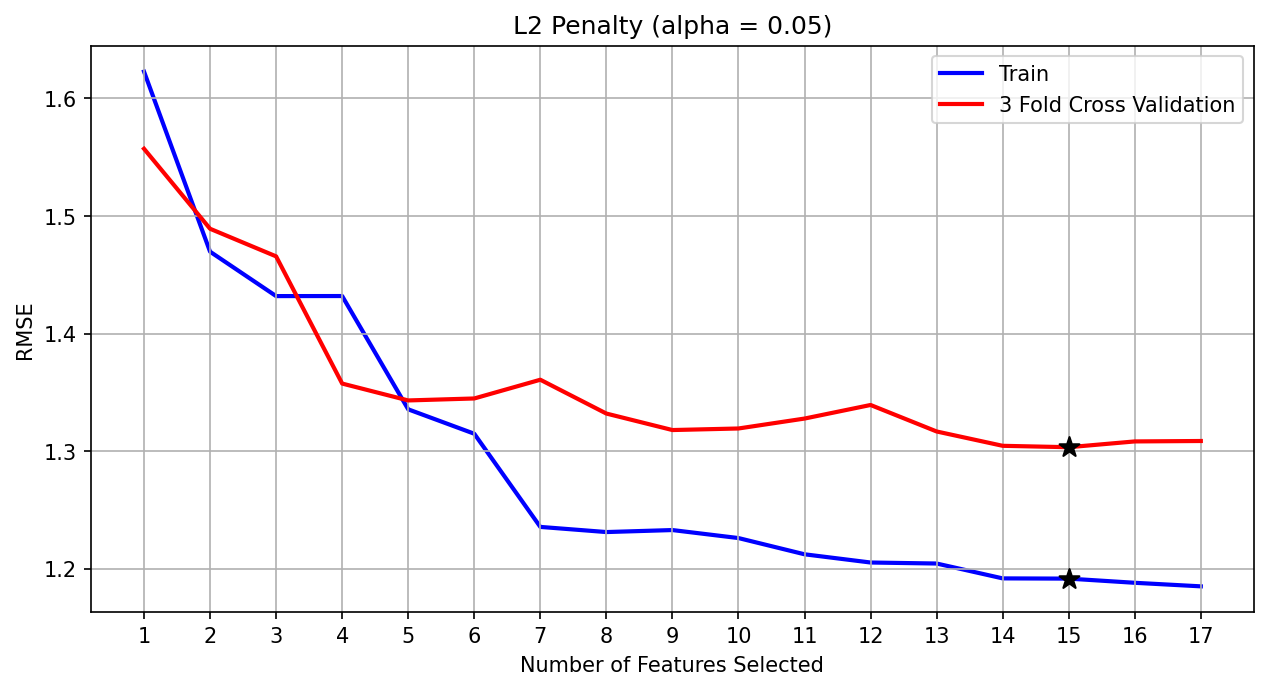

In [24]:
# Plot grid search 2 results

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(components, train_rmse, c='b', lw=2, label="Train", zorder=1)
plt.plot(components, cv_rmse, c='r', lw=2, label='3 Fold Cross Validation', zorder=2)

plt.scatter(components[14], train_rmse[14], c='k', s=100, marker='*', zorder=3)
plt.scatter(components[14], cv_rmse[14], c='k', s=100, marker='*', zorder=4)

plt.xticks(components)
plt.xlabel("Number of Features Selected")
plt.ylabel("RMSE")
plt.title("L2 Penalty (alpha = 0.05)")

plt.legend(loc='upper right')
plt.grid()
plt.show()

### SFS QR

In [32]:
# Grid Search - COMP. EXPENSIVE

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

parameters = {'n_features_to_select': [10, 12, 14, 16, 18, 20, 22, 24], 'alpha': [1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0]}

model_rmse = np.zeros((8, 8))

for i, n in enumerate(parameters['n_features_to_select']):
    for j, a in tqdm(enumerate(parameters['alpha'])):
        m = SFS_QR(n_features_to_select=n, alpha=a)

        kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                                
        val_metrics = cross_validate(m,
                                     X, y,
                                     scoring=["neg_mean_squared_error"],
                                     cv=kf,
                                     n_jobs=-1, 
                                     verbose=0)
        
        model_rmse[i, j] = np.sqrt(np.mean(-val_metrics["test_neg_mean_squared_error"]))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [35]:
# Grid Search 2 - COMP. EXPENSIVE

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

parameters = {'n_features_to_select': [24, 26, 28, 30, 32], 'alpha': [1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0]}

model_rmse = np.zeros((8, 8))

for i, n in enumerate(parameters['n_features_to_select']):
    for j, a in tqdm(enumerate(parameters['alpha'])):
        m = SFS_QR(n_features_to_select=n, alpha=a)

        kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                                
        val_metrics = cross_validate(m,
                                     X, y,
                                     scoring=["neg_mean_squared_error"],
                                     cv=kf,
                                     n_jobs=-1, 
                                     verbose=0)
        
        model_rmse[i, j] = np.sqrt(np.mean(-val_metrics["test_neg_mean_squared_error"]))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [5]:
# Grid Search 3 - COMP. EXPENSIVE

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

parameters = {'n_features_to_select': [34, 36, 38, 40, 42, 44, 46, 48, 50], 'alpha': [1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0]}

model_rmse = np.zeros((10, 8))

for i, n in enumerate(parameters['n_features_to_select']):
    for j, a in tqdm(enumerate(parameters['alpha'])):
        m = SFS_QR(n_features_to_select=n, alpha=a)

        kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                                
        val_metrics = cross_validate(m,
                                     X, y,
                                     scoring=["neg_mean_squared_error"],
                                     cv=kf,
                                     n_jobs=-1, 
                                     verbose=0)
        
        model_rmse[i, j] = np.sqrt(np.mean(-val_metrics["test_neg_mean_squared_error"]))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

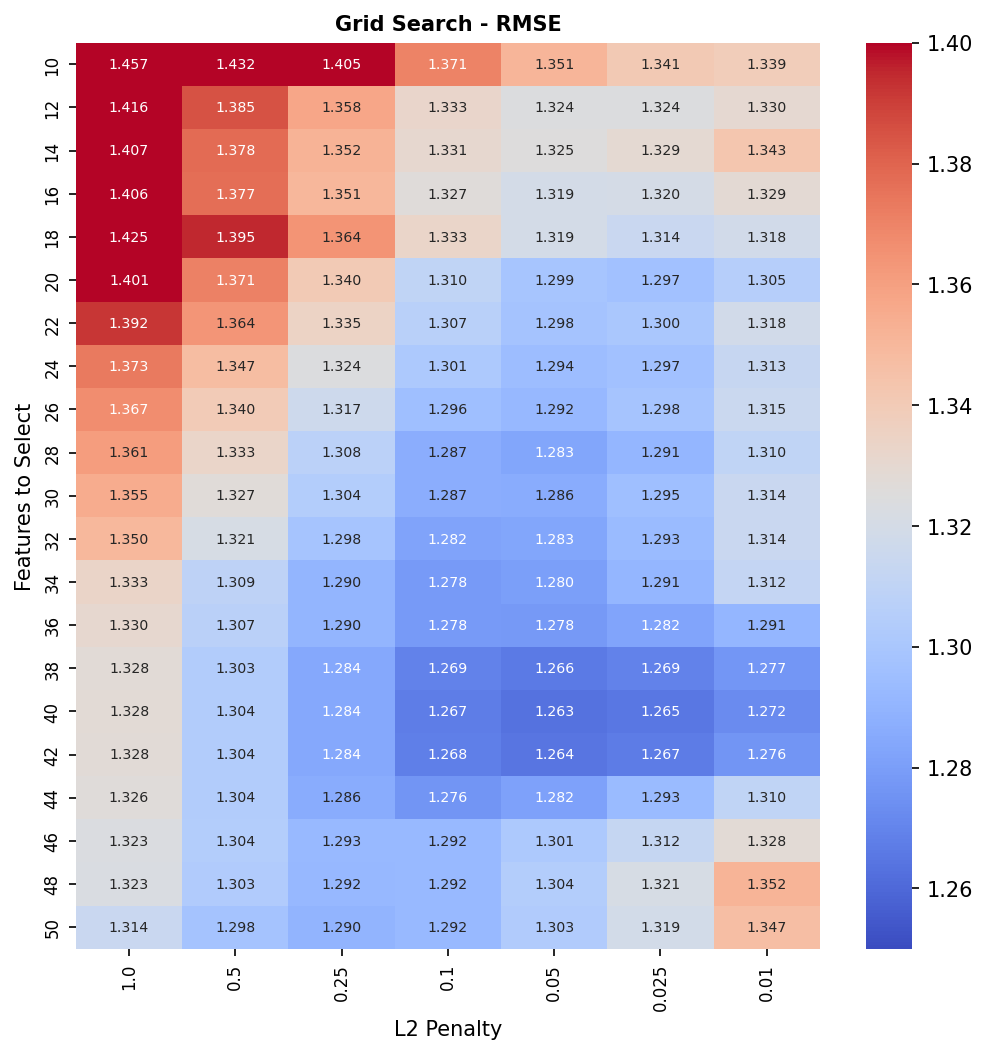

In [54]:
# Plot grid search results

grid_search = pd.read_excel("C:\\Users\\argan\\OneDrive\\Desktop\\DDP\\Final Data\\GridSearch.xlsx", header=0, index_col=0)
grid_search = grid_search.iloc[:, :-1]

plt.figure(figsize=(8, 8), dpi=150)

sns.heatmap(grid_search, 
            annot=grid_search.round(decimals=3), 
            fmt=".3f", 
            vmin=1.25, vmax=1.4, 
            cmap="coolwarm", 
            annot_kws={"size":6.75},
            linewidths=0, 
            linecolor='black')

plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8)

plt.xlabel("L2 Penalty")
plt.ylabel("Features to Select")

plt.title("Grid Search - RMSE", fontweight="bold", fontsize=10)
plt.show()

In [65]:
# Grid Search 4 - Redundant - Plotting purpose

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

components = np.arange(10, 52, 2)

train_rmse = np.zeros(len(components))

cv_rmse = np.zeros(len(components))
cv_rmse_std = np.zeros(len(components))

for i, n in tqdm(enumerate(components)):

    regressor = SFS_QR(n_features_to_select=n, alpha=0.05)

    regressor.fit(X, y)

    y_pred = regressor.predict(X).squeeze()

    rmse_train = np.sqrt(mean_squared_error(y, y_pred))

    # Calculate Cross-Validation Metrics
    kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                            
    val_metrics = cross_validate(regressor,
                                 X, y,
                                 scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                                 cv=kf,
                                 n_jobs=-1, 
                                 verbose=0)
    
    rmse_cv = np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error']))
    rmse_std_cv = np.std(-val_metrics['test_neg_mean_squared_error'])

    train_rmse[i] = rmse_train
    cv_rmse[i] = rmse_cv
    cv_rmse_std[i] = rmse_std_cv

0it [00:00, ?it/s]

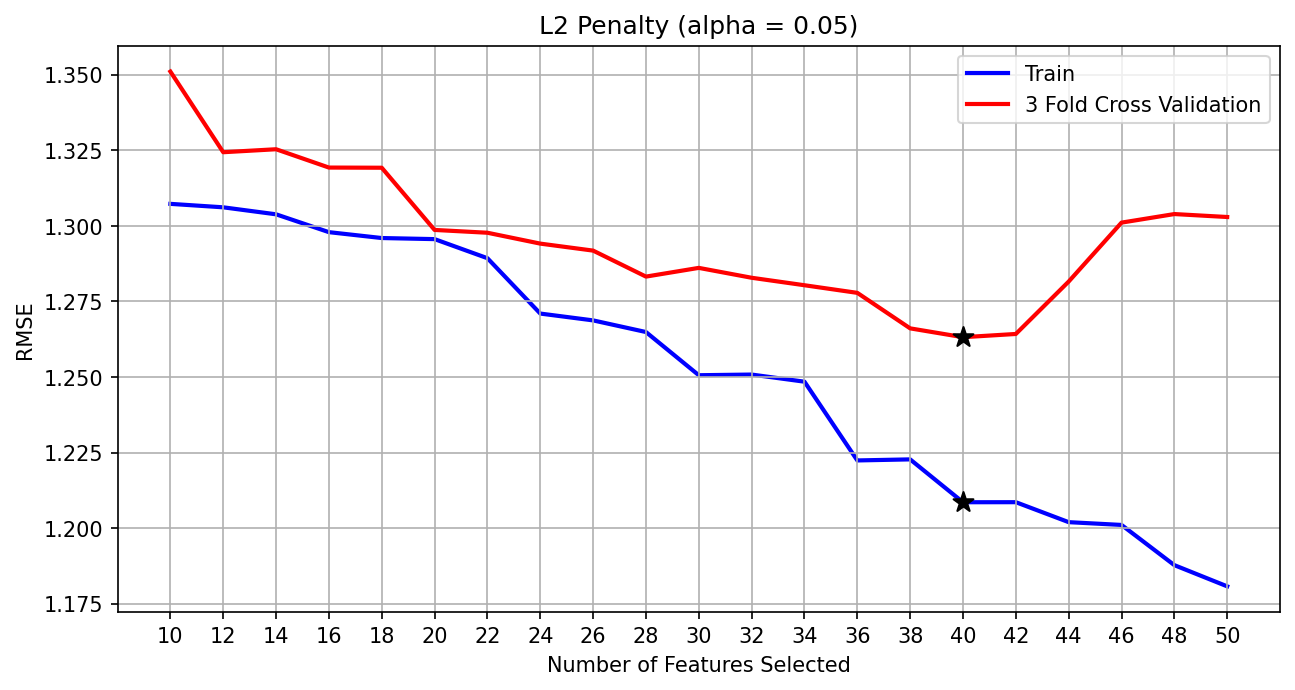

In [66]:
# Plot grid search 42 results

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(components, train_rmse, c='b', lw=2, label="Train", zorder=1)
plt.plot(components, cv_rmse, c='r', lw=2, label='3 Fold Cross Validation', zorder=2)

plt.scatter(components[15], train_rmse[15], c='k', s=100, marker='*', zorder=3)
plt.scatter(components[15], cv_rmse[15], c='k', s=100, marker='*', zorder=4)

plt.xticks(components)
plt.xlabel("Number of Features Selected")
plt.ylabel("RMSE")
plt.title("L2 Penalty (alpha = 0.05)")

plt.legend(loc='upper right')
plt.grid()
plt.show()

In [10]:
# Train and validate on optimal hyperparameters.

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

regressor = SFS_QR(n_features_to_select=40, alpha=0.05)

regressor.fit(X, y)

y_pred = regressor.predict(X).squeeze()

# Calculate Standardized Residuals
std = np.std(y.squeeze()-y_pred.squeeze())

res = (y.squeeze()-y_pred.squeeze())/std

# Calculate Validation Metrics
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                         
val_metrics = cross_validate(regressor,
                             X, y,
                             scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                             cv=kf,
                             n_jobs=-1, 
                             verbose=0)

print("TRAINING: -")
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
print("MAE:", np.sqrt(mean_absolute_error(y, y_pred)))
print("R2 Score:", r2_score(y, y_pred))
print()
print("VALIDATION: -")
print("RMSE:", np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error'])), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_squared_error']))
print("MAE:", -np.mean(val_metrics['test_neg_mean_absolute_error']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_absolute_error']))
print("R2 Score:", np.mean(val_metrics['test_r2']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_r2']))

TRAINING: -
RMSE: 1.2085646039458269
MAE: 0.9607202546387413
R2 Score: 0.4453890710290631

VALIDATION: -
RMSE: 1.2631754010238572, Standard Deviation: 0.42415990140004084
MAE: 0.9898658792706397, Standard Deviation: 0.14964691320578857
R2 Score: 0.37372071511244176, Standard Deviation: 0.06709383764686508


Residual Analysis

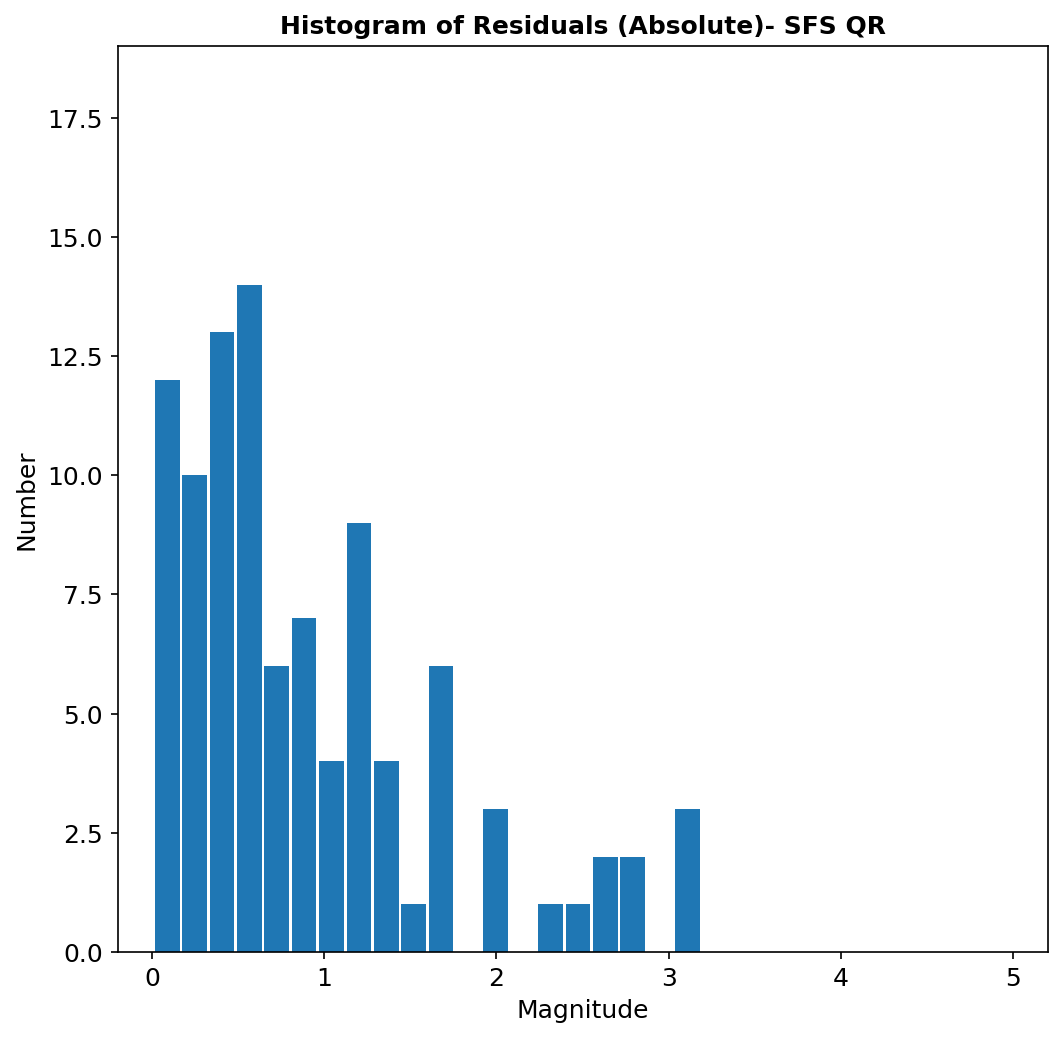

In [12]:
plt.figure(figsize=(8, 8), dpi=150)
plt.hist(np.abs(y-y_pred), bins=20, rwidth=0.9)
plt.xlim(-0.2, 5.2)
plt.ylim(0, 19)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Magnitude", fontsize=12)
plt.ylabel("Number", fontsize=12)

plt.title("Histogram of Residuals (Absolute)- SFS QR", fontsize=12, fontweight='bold')
plt.show()

### SVR

In [77]:
# Grid Search

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

parameters = {'degree': [2, 3, 4, 5], 'C': [0.1, 0.5, 1, 2, 5, 10, 15, 20]}

model_rmse = np.zeros((4, 8))

for i, n in enumerate(parameters['degree']):
    for j, a in tqdm(enumerate(parameters['C'])):
        m = SVR(kernel='poly', degree=n, C=a)

        kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                                
        val_metrics = cross_validate(m,
                                     X, y,
                                     scoring=["neg_mean_squared_error"],
                                     cv=kf,
                                     n_jobs=-1, 
                                     verbose=0)
        
        model_rmse[i, j] = np.sqrt(np.mean(-val_metrics["test_neg_mean_squared_error"]))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

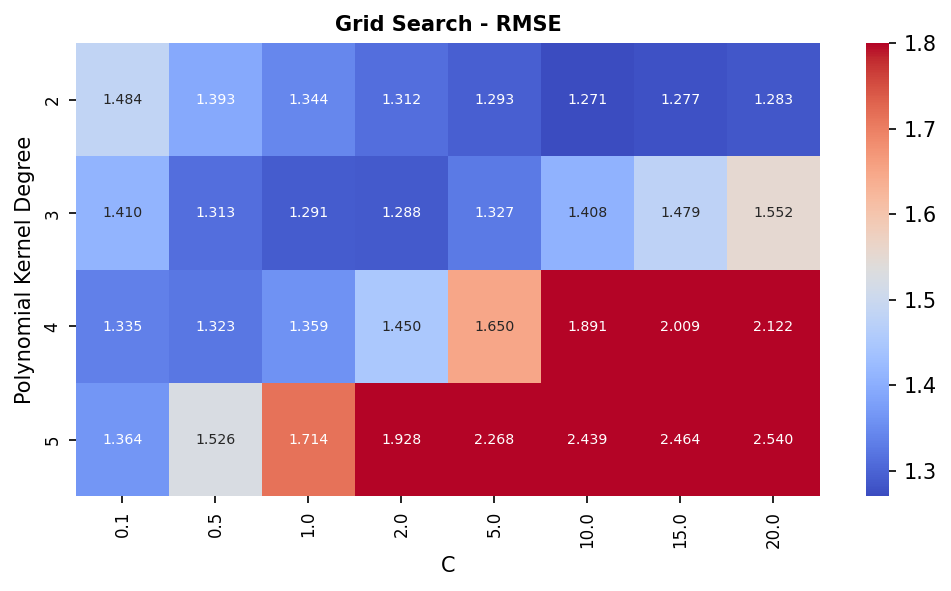

In [80]:
# Plot grid search results

grid_search = pd.DataFrame(model_rmse)
grid_search.columns = parameters['C']
grid_search.index = parameters['degree']

plt.figure(figsize=(8, 4), dpi=150)

sns.heatmap(grid_search, 
            annot=grid_search.round(decimals=3), 
            fmt=".3f", 
            vmin=1.27, vmax=1.8, 
            cmap="coolwarm", 
            annot_kws={"size":6.75},
            linewidths=0, 
            linecolor='black')

plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8)

plt.xlabel("C")
plt.ylabel("Polynomial Kernel Degree")

plt.title("Grid Search - RMSE", fontweight="bold", fontsize=10)
plt.show()

In [13]:
# Train and validate on optimal hyperparameters.

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

regressor = SVR(kernel='poly', degree=2, C=10)

regressor.fit(X, y)

y_pred = regressor.predict(X).squeeze()

# Calculate Standardized Residuals
std = np.std(y.squeeze()-y_pred.squeeze())

res = (y.squeeze()-y_pred.squeeze())/std

# Calculate Validation Metrics
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                         
val_metrics = cross_validate(regressor,
                             X, y,
                             scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                             cv=kf,
                             n_jobs=-1, 
                             verbose=0)

print("TRAINING: -")
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
print("MAE:", np.sqrt(mean_absolute_error(y, y_pred)))
print("R2 Score:", r2_score(y, y_pred))
print()
print("VALIDATION: -")
print("RMSE:", np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error'])), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_squared_error']))
print("MAE:", -np.mean(val_metrics['test_neg_mean_absolute_error']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_absolute_error']))
print("R2 Score:", np.mean(val_metrics['test_r2']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_r2']))

TRAINING: -
RMSE: 1.1659304294937394
MAE: 0.919411698549953
R2 Score: 0.4838285777238557

VALIDATION: -
RMSE: 1.2711845794466863, Standard Deviation: 0.5367499785423839
MAE: 0.9896805708945978, Standard Deviation: 0.17791791349332342
R2 Score: 0.3785432845487902, Standard Deviation: 0.06576622546355267


Residual Analysis

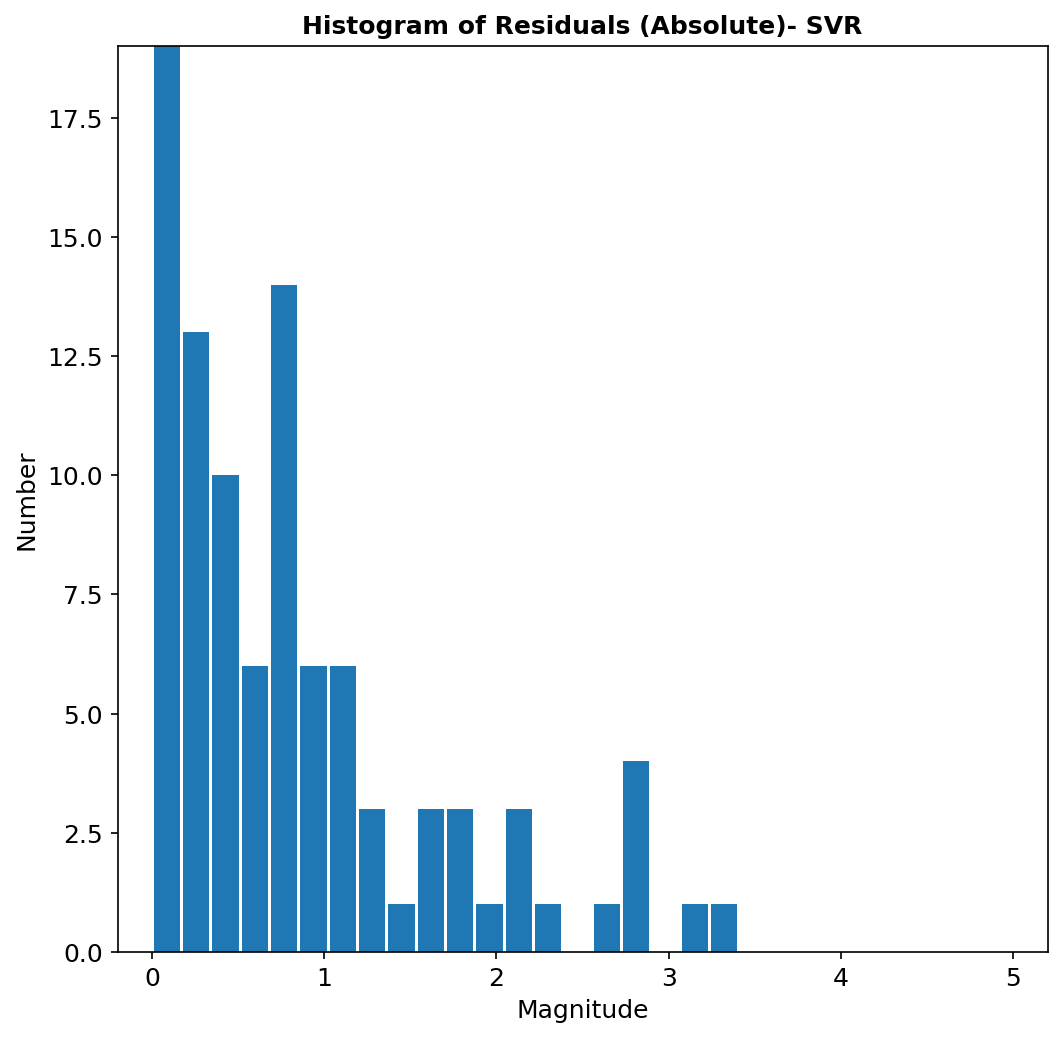

In [14]:
plt.figure(figsize=(8, 8), dpi=150)
plt.hist(np.abs(y-y_pred), bins=20, rwidth=0.9)
plt.xlim(-0.2, 5.2)
plt.ylim(0, 19)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Magnitude", fontsize=12)
plt.ylabel("Number", fontsize=12)

plt.title("Histogram of Residuals (Absolute)- SVR", fontsize=12, fontweight='bold')
plt.show()

### Voting Regressor

In [4]:
X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

r1 = PLSR(n_components=5)
r2 = SFS_QR(n_features_to_select=40, alpha=0.05)
r3 = SVR(kernel='poly', degree=2, C=10)

regressor = VotingRegressor([('PLSR', r1), ('SFS_QR', r2), ('SVR', r3)])

regressor.fit(X, y)

y_pred = regressor.predict(X).squeeze()

# Calculate Standardized Residuals
std = np.std(y.squeeze()-y_pred.squeeze())

res = (y.squeeze()-y_pred.squeeze())/std

# Calculate Validation Metrics
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                         
val_metrics = cross_validate(regressor,
                             X, y,
                             scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                             cv=kf,
                             n_jobs=-1, 
                             verbose=0)

print("TRAINING: -")
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
print("MAE:", np.sqrt(mean_absolute_error(y, y_pred)))
print("R2 Score:", r2_score(y, y_pred))
print()
print("VALIDATION: -")
print("RMSE:", np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error'])), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_squared_error']))
print("MAE:", -np.mean(val_metrics['test_neg_mean_absolute_error']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_absolute_error']))
print("R2 Score:", np.mean(val_metrics['test_r2']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_r2']))

TRAINING: -
RMSE: 1.157213195646217
MAE: 0.937478272374239
R2 Score: 0.49151817223111016

VALIDATION: -
RMSE: 1.2487847593534849, Standard Deviation: 0.4776480710296814
MAE: 0.9786145778695214, Standard Deviation: 0.15373569228362763
R2 Score: 0.3947069477224526, Standard Deviation: 0.06472174021580321


Residual Analysis

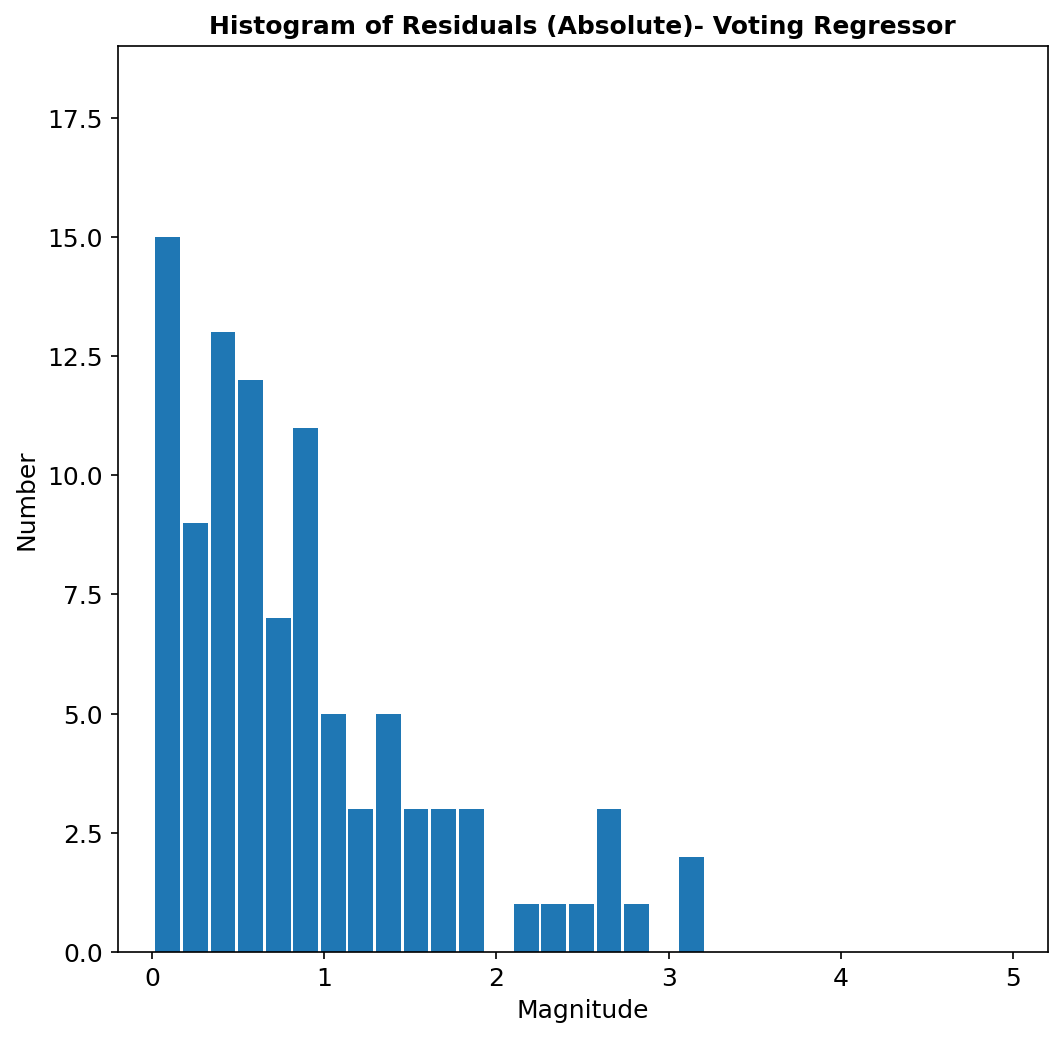

In [6]:
plt.figure(figsize=(8, 8), dpi=150)
plt.hist(np.abs(y-y_pred), bins=20, rwidth=0.9)
plt.xlim(-0.2, 5.2)
plt.ylim(0, 19)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Magnitude", fontsize=12)
plt.ylabel("Number", fontsize=12)

plt.title("Histogram of Residuals (Absolute)- Voting Regressor", fontsize=12, fontweight='bold')
plt.show()